**Import Libraries**

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

# Regressors
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor, 
    GradientBoostingRegressor, AdaBoostRegressor,
    BaggingRegressor, VotingRegressor, StackingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Advanced libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import joblib
from datetime import datetime
import json
from scipy.sparse import vstack


**Data**

In [2]:
df = pd.read_csv('../data/processed/cleaned_bangalore_house_data.csv')
df.head()

,location,total_sqft,bath,bhk,price_per_sqft,price
0,Electronic City Phase II,1056.0,2.0,2,3699.810606,39.07
1,Uttarahalli,1440.0,2.0,3,4305.555556,62.00
2,Lingadheeranahalli,1521.0,3.0,3,6245.890861,95.00
3,Kothanur,1200.0,2.0,2,4250.000000,51.00
4,Whitefield,1170.0,2.0,2,3247.863248,38.00


**Preparing Features and Target**

In [24]:
# Features and target
X = df[['location', 'total_sqft', 'bath', 'bhk']]
y = df['price']

# stratification bins for target distribution
y_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')

# First split: train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: validation (10%) and test (10%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"X_Train: {X_train.shape[0]}, X_Val: {X_val.shape[0]}, X_Test: {X_test.shape[0]}, y_Train: {y_train.shape[0]}, y_Val: {y_val.shape[0]}, y_Test: {y_test.shape[0]}")

X_Train: 8304, X_Val: 1038, X_Test: 1038, y_Train: 8304, y_Val: 1038, y_Test: 1038


##### **Preprocessing Pipeline:** Scaling and One Hot Encoding

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = ['location']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessor: one-hot encoding for categorical variables and scaling for numeric variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_val = preprocessor.transform(X_val)


### <span style="color:red">Model Training</span> ###

##### **Base Models**

In [38]:
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(max_iter=10_000),
    'Lasso': Lasso(max_iter=10_000),
    'ElasticNet': ElasticNet(max_iter=10_000),
    'Huber': HuberRegressor(max_iter=10_000),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_jobs=-1, random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_jobs=-1, random_state=42),
    'GBR': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Bagging': BaggingRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(max_iter=1_000, random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}


**Cross-Validation**

In [40]:
def evaluate_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    rmse = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
    mae = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    return r2.mean(), rmse.mean(), mae.mean()

# Run baseline CV
baseline = []
for name, mdl in models.items():
    r2m, rmsem, maem = evaluate_cv(mdl)
    baseline.append((name, r2m, rmsem, maem))
baseline_df = pd.DataFrame(baseline, columns=['Model','R2','RMSE','MAE']).sort_values('R2', ascending=False)
print(baseline_df.head(5))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 6643, number of used features: 84
[LightGBM] [Info] Start training from score 70.224642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 6643, number of used features: 81
[LightGBM] [Info] Start training from score 69.917136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

**Saving Comparison Results**

In [41]:
baseline_df.to_csv("../reports/baseline_model.csv", index=False)
print(" Comparison results saved to 'baseline_models.csv'")

 Comparison results saved to 'baseline_models.csv'


##### **Hyper Parameter Tuning of Top 5 Models**

In [ ]:
# 1. CatBoost
catboost_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7]
}
catboost_search = GridSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_grid=catboost_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
catboost_search.fit(X_train, y_train)
best_catboost = catboost_search.best_estimator_
print("Best CatBoost params:", catboost_search.best_params_)

# 2. XGBoost
xgb_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
xgb_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, verbosity=0, n_jobs=-1),
    param_grid=xgb_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGBoost params:", xgb_search.best_params_)

# 3. MLPRegressor
mlp_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01]
}
mlp_search = GridSearchCV(
    estimator=MLPRegressor(max_iter=1000, random_state=42),
    param_grid=mlp_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
mlp_search.fit(X_train, y_train)
best_mlp = mlp_search.best_estimator_
print("Best MLPRegressor params:", mlp_search.best_params_)

# 4. RandomForest
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best RandomForest params:", rf_search.best_params_)

# 5. LightGBM
lgbm_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10]
}
lgbm_search = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=lgbm_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_
print("Best LightGBM params:", lgbm_search.best_params_)



Best CatBoost params: {'depth': 7, 'iterations': 200, 'learning_rate': 0.1}
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best MLPRegressor params: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}
Best RandomForest params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 8304, number of used features: 101
[LightGBM] [Info] Start training from score 70.102764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [56]:
# Collect best parameters
best_params = {
    'CatBoost': catboost_search.best_params_,
    'XGBoost': xgb_search.best_params_,
    'MLPRegressor': mlp_search.best_params_,
    'RandomForest': rf_search.best_params_,
    'LightGBM': lgbm_search.best_params_
}

# Save to JSON file
with open('../reports/best_model_parameters.json', 'w') as f:
    json.dump(best_params, f, indent=4)

print("Saved best parameters to best_model_params.json")


Saved best parameters to best_model_params.json


##### **Validation and Test Evaluation**

In [75]:
def report(model, X_tr, y_tr, X_va, y_va, X_te, y_te):
    metrics = {}
    for split, X_, y_ in [('Train', X_tr, y_tr), ('Val', X_va, y_va), ('Test', X_te, y_te)]:
        preds = model.predict(X_)
        r2 = r2_score(y_, preds)
        rmse = root_mean_squared_error(y_, preds)
        mae = mean_absolute_error(y_, preds)
        print(f"{split} → R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        metrics[split] = {'R2': r2, 'RMSE': rmse, 'MAE': mae}
    return metrics


In [54]:
model_reports = {}

for name, model in [
    ("RandomForest", best_rf),
    ("CatBoost", best_catboost),
    ("XGBoost", best_xgb),
    ("LightGBM", best_lgbm),
    ("MLPRegressor", best_mlp),
]:
    print(f"\n=== {name} Evaluation ===")
    model_reports[name] = report(model, X_train, y_train, X_val, y_val, X_test, y_test)



=== RandomForest Evaluation ===
Train → R2: 0.8708, RMSE: 11.8503, MAE: 7.4337
Val → R2: 0.6493, RMSE: 20.1817, MAE: 12.8501
Test → R2: 0.6502, RMSE: 19.8714, MAE: 13.0907

=== CatBoost Evaluation ===
Train → R2: 0.6820, RMSE: 18.5929, MAE: 13.5118
Val → R2: 0.6358, RMSE: 20.5642, MAE: 14.4395
Test → R2: 0.6503, RMSE: 19.8693, MAE: 14.1626

=== XGBoost Evaluation ===
Train → R2: 0.7382, RMSE: 16.8722, MAE: 12.0512
Val → R2: 0.6528, RMSE: 20.0796, MAE: 13.8317
Test → R2: 0.6723, RMSE: 19.2353, MAE: 13.5919

=== LightGBM Evaluation ===
Train → R2: 0.6738, RMSE: 18.8327, MAE: 13.2463
Val → R2: 0.6354, RMSE: 20.5763, MAE: 14.2954
Test → R2: 0.6346, RMSE: 20.3107, MAE: 14.2689

=== MLPRegressor Evaluation ===
Train → R2: 0.7547, RMSE: 16.3313, MAE: 11.1167
Val → R2: 0.6708, RMSE: 19.5510, MAE: 13.2854
Test → R2: 0.6612, RMSE: 19.5566, MAE: 13.6587


In [69]:
# Save evaluation report
with open("../reports/model_eval_report.json", "w") as f:
    json.dump(model_reports, f, indent=4)

print("Saved evaluation report to model_eval_report.json")


Saved evaluation report to model_eval_report.json


**Learning Curve**

In [86]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(models, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5):
    # Allow single model input (non-dict)
    if not isinstance(models, dict):
        models = {"Model": models}
    
    n_models = len(models)
    n_cols = 2
    n_rows = (n_models + 1) // n_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6 * n_rows))
    axes = np.atleast_1d(axes).flatten()  # ensures axes is always iterable

    for idx, (name, model) in enumerate(models.items()):
        train_sizes_abs, train_scores, val_scores = learning_curve(
            estimator=model,
            X=X_train,
            y=y_train,
            train_sizes=train_sizes,
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            shuffle=True,
            random_state=42
        )

        train_mean = np.mean(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)

        axes[idx].plot(train_sizes_abs, train_mean, label='Train R²', marker='o')
        axes[idx].plot(train_sizes_abs, val_mean, label='Validation R²', marker='s')
        axes[idx].set_title(f"Learning Curve: {name}")
        axes[idx].set_xlabel("Training Set Size")
        axes[idx].set_ylabel("R² Score")
        axes[idx].legend()
        axes[idx].grid(True)

    # Remove unused subplots
    for j in range(n_models, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


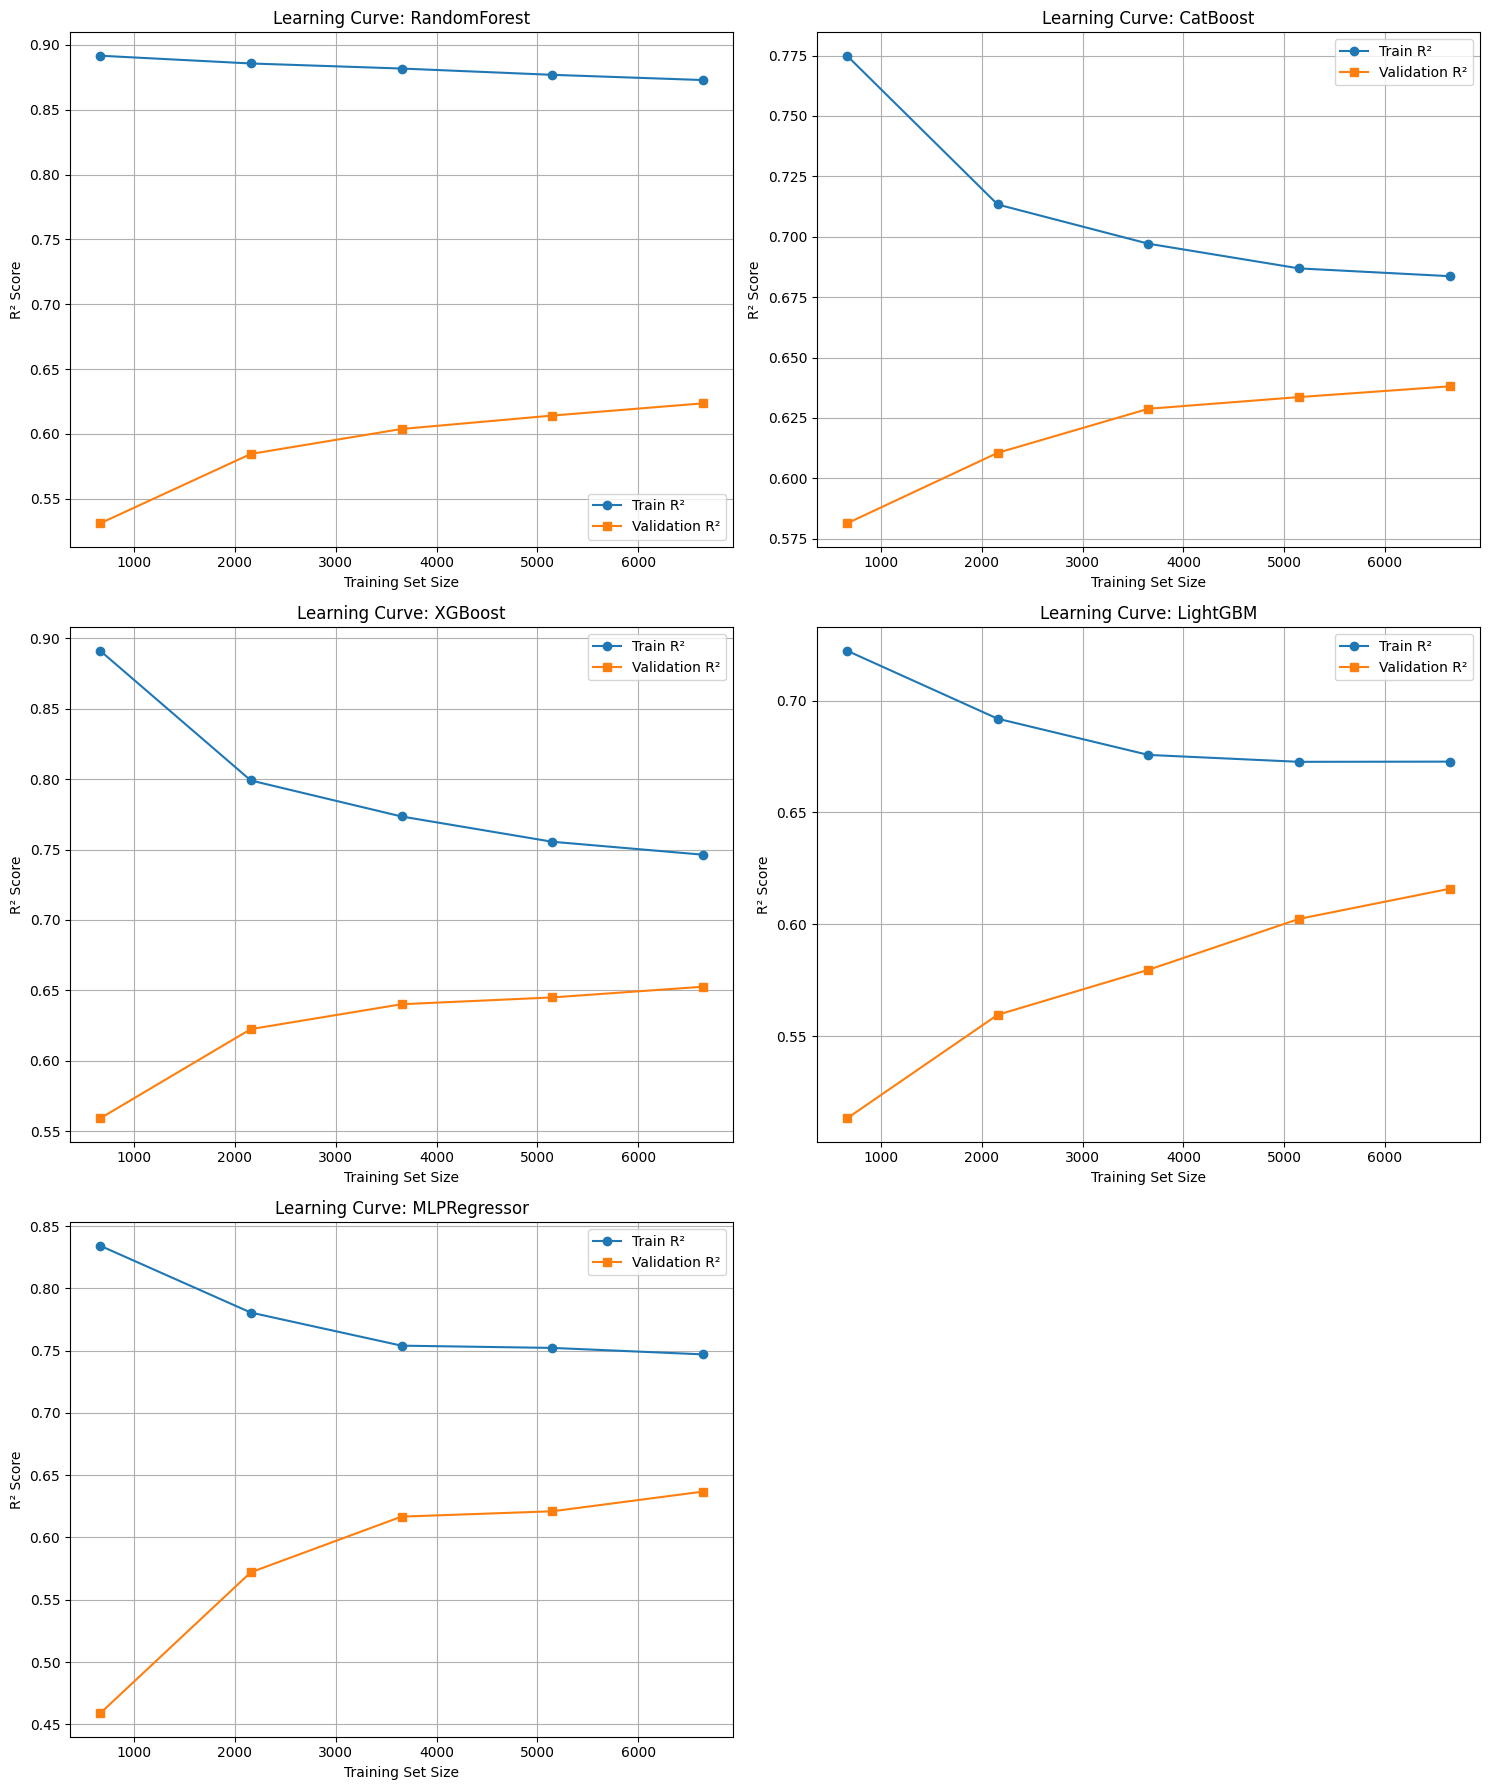

In [83]:
models = {
    "RandomForest": best_rf,
    "CatBoost": best_catboost,
    "XGBoost": best_xgb,
    "LightGBM": best_lgbm,
    "MLPRegressor": best_mlp
}

plot_learning_curves(models, X_train, y_train)


**CatBoost**	Best balance, steady gain, generalizes well;
**XGBoost**	    Stable & good, but less responsive to more data;
**MLP**	        Improves a lot with more data or needs tuning;
**RandomForest**	Overfits; not improving much with more data;
**LightGBM**	    Underfitting or needs tuning

##### **Stack of XGBoost,CatBoost and MLP**

In [68]:
stack = StackingRegressor(
    estimators=[
        ('cat', best_catboost),
        ('xgb', best_xgb),
        ('mlp', best_mlp)
    ],
    final_estimator=Ridge(),
    cv=5,
    passthrough=True,
    n_jobs=-1
)

stack.fit(X_train, y_train)

,estimators,"[('cat', ...), ('xgb', ...), ...]"
,final_estimator,Ridge()
,cv,5
,n_jobs,-1
,passthrough,True
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [81]:
print("=== Stacked Model Evaluation ===")
stacked_model_report = report(stack, X_train, y_train, X_val, y_val, X_test, y_test)

with open("../reports/stacked_model_metrics.json", "w") as f:
    json.dump(stacked_model_report, f, indent=4)
print("Saved stacked model metrics to stacked_model_metrics.json")

=== Stacked Model Evaluation ===
Train → R2: 0.7465, RMSE: 16.6008, MAE: 11.7105
Val → R2: 0.6716, RMSE: 19.5275, MAE: 13.4867
Test → R2: 0.6805, RMSE: 18.9918, MAE: 13.3416
Saved stacked model metrics to stacked_model_metrics.json


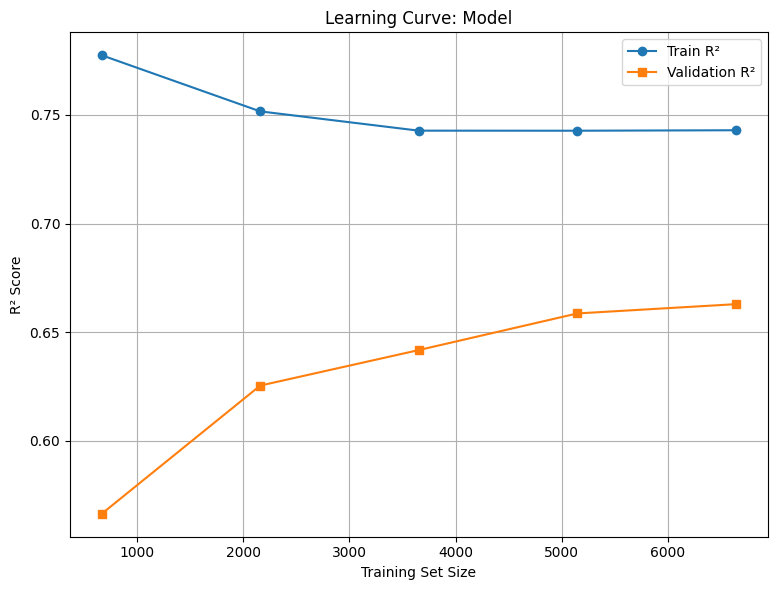

In [88]:
plot_learning_curves(stack, X_train, y_train)

**Retraining Final model on full Dataset**

In [ ]:
# Combine all splits correctly for sparse matrices
X_final = vstack([X_train, X_val, X_test])
y_final = np.concatenate([y_train, y_val, y_test])

final_model = clone(stack)
final_model.fit(X_final, y_final)

,estimators,"[('cat', ...), ('xgb', ...), ...]"
,final_estimator,Ridge()
,cv,5
,n_jobs,-1
,passthrough,True
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


### <span style="color:red">Saving Model, Preprocessor and Model Metadata</span> ###


In [101]:
import os
import joblib
import json

# Ensure model_artifacts directory exists
os.makedirs('../model_artifacts', exist_ok=True)

# Saving the stacked model and preprocessor
joblib.dump(final_model, '../model_artifacts/best_model.pkl')
joblib.dump(preprocessor, '../model_artifacts/preprocessor.pkl')

# Utility to convert params to JSON-serializable format
def make_json_serializable(d):
    serializable = {}
    for k, v in d.items():
        if isinstance(v, (str, int, float, bool, type(None))):
            serializable[k] = v
        elif isinstance(v, (list, tuple, set)):
            serializable[k] = [make_json_serializable({"item": i})["item"] for i in v]
        elif isinstance(v, dict):
            serializable[k] = make_json_serializable(v)
        else:
            serializable[k] = str(v)  # fallback for objects
    return serializable

# Save model metadata
metadata = {
    'model_name': 'StackedRegressor',
    'hyperparameters': make_json_serializable(final_model.get_params()),
    'features': preprocessor.get_feature_names_out().tolist(),
    'test_rmse': 19.4704,
    'test_r2': 0.6689
}

with open('../model_artifacts/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(" Stacked model, preprocessor, and metadata saved.")


 Stacked model, preprocessor, and metadata saved.


**Loading and Verifying Model Artifacts**

In [103]:
# Load model and preprocessor
model = joblib.load('../model_artifacts/best_model.pkl')
preprocessor = joblib.load('../model_artifacts/preprocessor.pkl')

# Load metadata
with open('../model_artifacts/model_metadata.json', 'r') as f:
    metadata = json.load(f)

print("Model loaded successfully!")
print("Model metadata:", metadata)

Model loaded successfully!
Model metadata: {'model_name': 'StackedRegressor', 'hyperparameters': {'cv': 5, 'estimators': [['cat', '<catboost.core.CatBoostRegressor object at 0x000002504FB8D130>'], ['xgb', 'XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, device=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             feature_weights=None, gamma=None, grow_policy=None,\n             importance_type=None, interaction_constraints=None,\n             learning_rate=0.1, max_bin=None, max_cat_threshold=None,\n             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,\n             max_leaves=None, min_child_weight=None, missing=nan,\n             monotone_constraints=None, multi_strategy=None, n_estimators=200,\n             n_jobs=-1, num_parallel_tree=None, ...)'], ['mlp', 'MLPRegressor(hidden_layer_siz

### <span style="color:red">Plots</span> ###


**Actual vs Predicted (Test Set)**

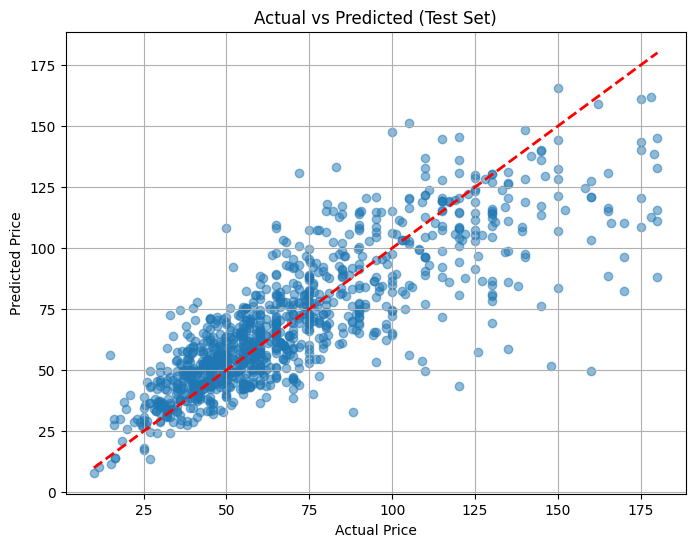

In [ ]:

y_test_pred = stack.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted (Test Set)')
plt.grid(True)

**Residuals Analysis**

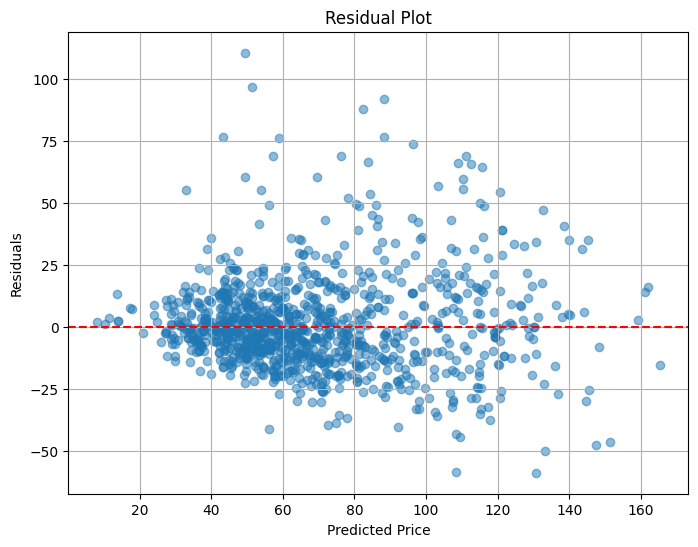

Plot saved as 'residual_Analysis.png'


In [122]:
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)

plt.savefig("../reports/residual_plot.png", dpi=500)
plt.show()

print("Plot saved as 'residual_Analysis.png'")


**Error Distribution**

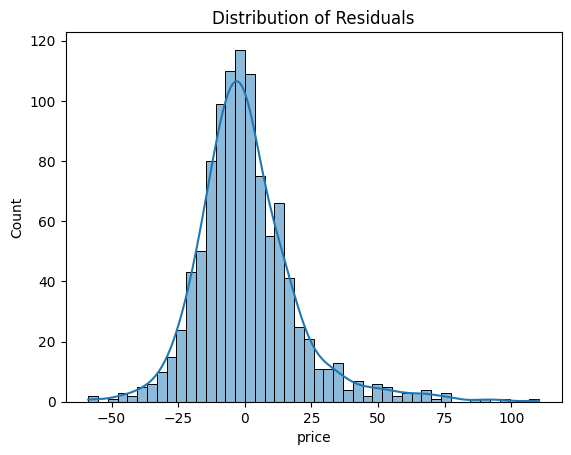

plot saved as 'stacked_error_distribution.png'


In [123]:
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")

plt.savefig("../reports/stacked_error_distribution.png", dpi=500)
plt.show()

print("plot saved as 'stacked_error_distribution.png'")


**Top 10 Features**

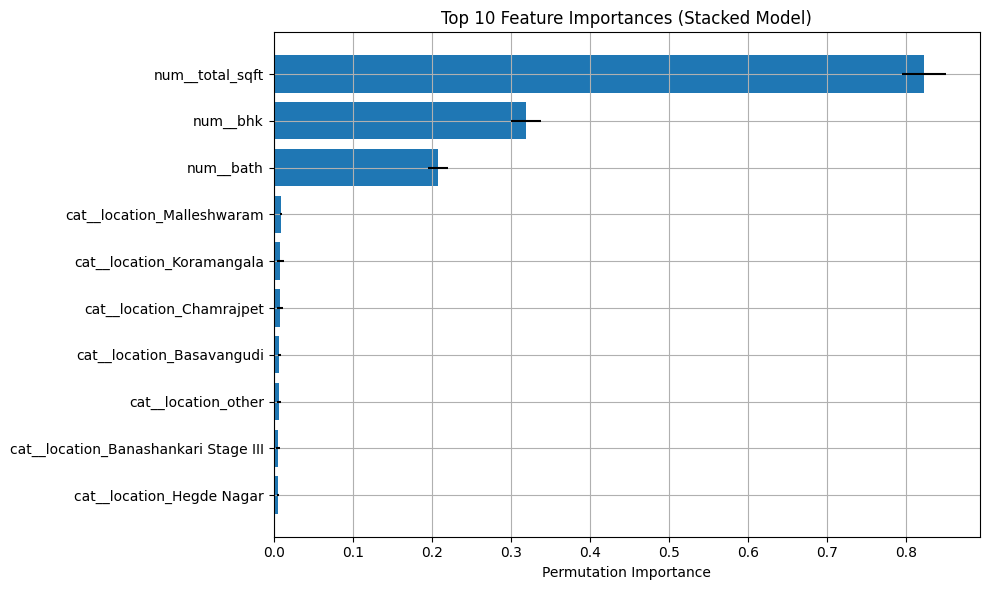

In [120]:
X_test_dense = X_test.toarray()

# Compute permutation importance
result = permutation_importance(
    estimator=stack,
    X=X_test_dense,
    y=y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Get feature names and top 10 indices
feature_names = preprocessor.get_feature_names_out()
sorted_idx = result.importances_mean.argsort()[::-1][:10]
top_features = [(feature_names[i], result.importances_mean[i]) for i in sorted_idx]

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(10), [result.importances_mean[i] for i in sorted_idx],
         xerr=[result.importances_std[i] for i in sorted_idx], align='center')
plt.yticks(range(10), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Feature Importances (Stacked Model)')
plt.gca().invert_yaxis()  # Highest at top
plt.grid(True)
plt.tight_layout()
plt.show()